In [2]:
# load our dependencies
import time
import numpy as np
import warnings
import matplotlib.pyplot as plt

from operator import itemgetter
from hyperopt import hp, fmin, rand, tpe, space_eval, Trials, STATUS_OK
from scipy.stats import randint, uniform, lognorm
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.cross_validation import train_test_split, cross_val_score

%matplotlib inline
plt.style.use("ggplot")
warnings.filterwarnings("ignore")

## Optimizing Hyper-parameters for Machine Learning (part 2)

part 1 https://github.com/Eric-Xu/nycdssg_talks/blob/master/08_03_2015_hyperparams/grid_and_random_search_demo.ipynb

**Objective:** Compare hyper-parameter results found through grid search, random search, and hyperopt search in predicting Boston housing prices.

In [3]:
# read in the Boston housing dataset
# description of dataset can be found at:
# https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/datasets/descr/boston_house_prices.rst
boston = load_boston()

# set our features and target
X, y = boston.data, boston.target

# peek at our dataset
print "Total rows:", X.shape[0]
print "Feature names:", boston["feature_names"]
print "First row features:", X[0]
print "First row target:", y[0]

Total rows: 506
Feature names: ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT' 'MEDV']
First row features: [  6.32000000e-03   1.80000000e+01   2.31000000e+00   0.00000000e+00
   5.38000000e-01   6.57500000e+00   6.52000000e+01   4.09000000e+00
   1.00000000e+00   2.96000000e+02   1.53000000e+01   3.96900000e+02
   4.98000000e+00]
First row target: 24.0


### MSE of default classifier

In [34]:
# initialize a gradient boosting classifier with default parameters
default_clf = GradientBoostingRegressor()

# inspect the default parameters
print default_clf

# run a 10-fold cross-validation with our classifier
mse_scores = cross_val_score(default_clf, X, y, cv=10, scoring="mean_squared_error")

# our goal is to find the parameter configuration that minimizes the mean squared error
print "MSE of default classifier", np.mean(-mse_scores)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss=ls,
             max_depth=3, max_features=None, min_samples_leaf=1,
             min_samples_split=2, n_estimators=100, random_state=None,
             subsample=1.0, verbose=0)
baseline MSE 18.4607094065


### Lowest MSE of best parameters found by `GridSearchCV`

In [61]:
# helper function to get best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1))[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean MSE score: {0:.3f}".format(score.mean_validation_score))
        print("Parameters: {0}\n".format(score.parameters))
        if i == 0: best_score = score
            
    return best_score

In [5]:
%%time

# define the parameter search space
param_grid = {
    "n_estimators": [100,500,1000],
    "learning_rate": [0.01,0.1,1],
    "max_depth": [1,5,10],
    "min_samples_split": [1,5,10],
    "loss": ["ls", "lad"]
}

# create a MSE scorer object
mse_scorer = make_scorer(mean_squared_error)

# instantiate our grid search running a 10-fold cross-validation for each parameter combination
grid_clf = GradientBoostingRegressor()
grid = GridSearchCV(grid_clf, param_grid, cv=10, scoring=mse_scorer, n_jobs=-1)

# fit grid search with data
grid.fit(X, y)

report(grid.grid_scores_)
print "Total {0} parameter combinations tested".format(len(grid.grid_scores_))

Model with rank: 1
Mean MSE score: 18.224
Parameters: {'min_samples_split': 1, 'loss': 'lad', 'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5}

Model with rank: 2
Mean MSE score: 18.542
Parameters: {'min_samples_split': 1, 'loss': 'lad', 'learning_rate': 0.1, 'n_estimators': 1000, 'max_depth': 5}

Model with rank: 3
Mean MSE score: 18.803
Parameters: {'min_samples_split': 5, 'loss': 'lad', 'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 10}

Total 162 parameter combinations tested
CPU times: user 1.11 s, sys: 224 ms, total: 1.33 s
Wall time: 14min 15s


### Lowest MSE of best parameters found by `RandomizedSearchCV`

In [6]:
%%time

# define the parameter search space
param_dist = {
    "n_estimators": randint(1,1000),
    "learning_rate": lognorm(0.5,0,1),
    "max_depth": randint(1, 10),
    "min_samples_split": randint(1, 10),
    "loss": ["ls", "lad"]
}

# create a MSE scorer object
mse_scorer = make_scorer(mean_squared_error)

# instantiate our random search running a 10-fold cross-validation for each trial
n_trials = 60
rand_clf = GradientBoostingRegressor()
rand = RandomizedSearchCV(rand_clf, param_dist, cv=10, scoring=mse_scorer, n_iter=n_trials, random_state=99, n_jobs=-1)

# fit random search with data
rand.fit(X, y)

report(rand.grid_scores_)
print "Total {0} trials sampled".format(n_trials)

Model with rank: 1
Mean MSE score: 21.595
Parameters: {'min_samples_split': 2, 'loss': 'ls', 'learning_rate': 0.49810380822227762, 'n_estimators': 657, 'max_depth': 4}

Model with rank: 2
Mean MSE score: 22.282
Parameters: {'min_samples_split': 6, 'loss': 'lad', 'learning_rate': 0.47755342721305821, 'n_estimators': 131, 'max_depth': 7}

Model with rank: 3
Mean MSE score: 22.588
Parameters: {'min_samples_split': 9, 'loss': 'lad', 'learning_rate': 0.81954375396634593, 'n_estimators': 859, 'max_depth': 1}

Total 60 trials sampled
CPU times: user 1.22 s, sys: 94.4 ms, total: 1.32 s
Wall time: 4min 29s


### Lowest MSE of best parameters found by `Hyperopt`

In [57]:
# define the parameter search space
space = {
    "n_estimators": hp.quniform("n_estimators", 1, 1000, 100),
    "learning_rate": hp.lognormal("learning_rate", -1, 1),
    "max_depth": hp.quniform("max_depth", 1, 10, 1),
    "min_samples_split": hp.quniform("min_samples_split", 1, 10, 1), 
    "loss": hp.choice("loss", ["ls", "lad"])
}

# define the objective function
def cv_score(params):
    print "Running 10-fold cv with", params
    
    # hack to convert hyperopt picked floats into ints
    params["n_estimators"] = int(params["n_estimators"])
    
    # initialize a classifier w the parameters suggested by the TPE algorithm
    hyperopt_clf = GradientBoostingRegressor().set_params(**params)

    # run a 10-fold cross-validation with our fitted classifier
    mse_scores = cross_val_score(hyperopt_clf, X, y, cv=10, scoring="mean_squared_error")
    score = np.mean(-mse_scores)

    # return the MSE score to be saved to our trials object
    return {"loss": score, "status": STATUS_OK}

In [58]:
%%time

# instantiate a trials object to keep track of search results
t = Trials()

# optimize our objective function using the TPE algorithm
n_trials = 10
hp_best_params = fmin(cv_score, space, algo=tpe.suggest, trials=t, max_evals=n_trials)

# all optimization results can now be accessed by the trials object
hp_best_score = t.best_trial["result"]["loss"]

print "\nLowest MSE score {0:0.3f} after {1} trials\nBest parameters {2}".format(hp_best_score, n_trials, hp_best_params)

Running 10-fold cv with {'min_samples_split': 4.0, 'loss': 'ls', 'learning_rate': 0.3418054100740955, 'n_estimators': 700.0, 'max_depth': 3.0}
Running 10-fold cv with {'min_samples_split': 8.0, 'loss': 'ls', 'learning_rate': 0.07391507869816935, 'n_estimators': 100.0, 'max_depth': 6.0}
Running 10-fold cv with {'min_samples_split': 2.0, 'loss': 'ls', 'learning_rate': 0.3919307536869097, 'n_estimators': 500.0, 'max_depth': 7.0}
Running 10-fold cv with {'min_samples_split': 2.0, 'loss': 'ls', 'learning_rate': 0.11778332421996421, 'n_estimators': 100.0, 'max_depth': 2.0}
Running 10-fold cv with {'min_samples_split': 1.0, 'loss': 'lad', 'learning_rate': 0.15380745917747565, 'n_estimators': 500.0, 'max_depth': 3.0}
Running 10-fold cv with {'min_samples_split': 3.0, 'loss': 'ls', 'learning_rate': 0.03829507693830701, 'n_estimators': 900.0, 'max_depth': 2.0}
Running 10-fold cv with {'min_samples_split': 3.0, 'loss': 'ls', 'learning_rate': 0.04042831712301156, 'n_estimators': 600.0, 'max_depth'

In [68]:
# total trials conducted
print len(t.trials)

# the first trial
print t.trials[0]

10
{'refresh_time': None, 'book_time': None, 'misc': {'tid': 0, 'idxs': {'min_samples_split': [0], 'loss': [0], 'learning_rate': [0], 'n_estimators': [0], 'max_depth': [0]}, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'vals': {'min_samples_split': [4.0], 'loss': [0], 'learning_rate': [0.3418054100740955], 'n_estimators': [700.0], 'max_depth': [3.0]}, 'workdir': None}, 'state': 2, 'tid': 0, 'exp_key': None, 'version': 0, 'result': {'status': 'ok', 'loss': 20.604219729380986}, 'owner': None, 'spec': None}


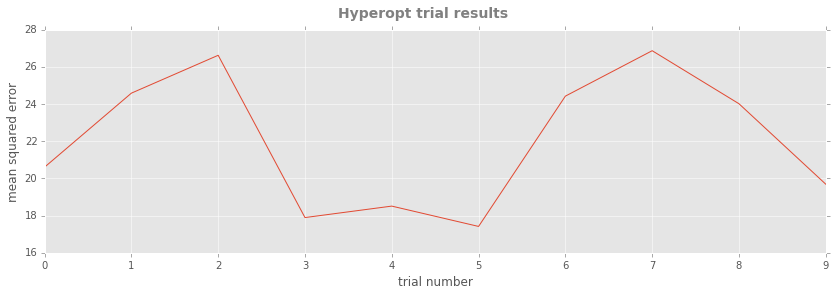

In [59]:
# plot the MSE after each trial
fig = plt.figure(figsize=(14,4))
fig.suptitle("Hyperopt trial results", fontsize=14, fontweight="bold", color="grey")
ax = fig.add_subplot(111)
# ax.xaxis.set_ticks(np.arange(0, 100, 5))
ax.set_xlabel("trial number")
ax.set_ylabel("mean squared error")
ax.plot(t.losses())
plt.show()

In [60]:
# inspect the score and parameter values for a single trial
trial_number = 5

print "MSE", t.trials[trial_number]["result"]["loss"]
print "Parameter values", t.trials[trial_number]["misc"]["vals"]

MSE 17.4174921561
Parameter values {'min_samples_split': [3.0], 'loss': [0], 'learning_rate': [0.03829507693830701], 'n_estimators': [900.0], 'max_depth': [2.0]}


### Summary of best scores and parameters

In [ ]:
print "Grid search\nLowest MSE {0:0.3f}\nParameters {1}".format(best_grid.mean_validation_score, best_grid.parameters)
print "Random search\nLowest MSE {0:0.3f}\nParameters {1}".format(best_rand.mean_validation_score, best_rand.parameters)
print "Hyperopt search\nLowest MSE {0:0.3f}\nParameters {1}".format(hp_best_score, hp_best_params)